## PPC

In [1]:
import sys
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import sparse

sns.set(context="notebook", font_scale=1.3, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

sys.path.append("../utils/")
from totalppc import TotalPosteriorPredictiveCheck as totalPPC
from scvi import set_seed

# colors = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]
# colors_3 = ["#9b59b6", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
colors_3 = ["#3B7EA1", "#D9661F", "#859438", "#EE1F60", "#00A598"]

set_seed(0)

In [2]:
anndataset_pbmc = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_malt = anndata.read(save_path + "malt_10k_protein_v3.h5ad")
anndataset_sln = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_sln = anndataset_sln[anndataset_sln.obs["batch_indices"] == 0]

In [3]:
dataset_pbmc = AnnDatasetFromAnnData(ad=anndataset_pbmc)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_pbmc.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_pbmc.uns["protein_names"],
)
dataset_pbmc.initialize_cell_measurement(protein_data)

dataset_malt = AnnDatasetFromAnnData(ad=anndataset_malt)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_malt.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_malt.uns["protein_names"],
)
dataset_malt.initialize_cell_measurement(protein_data)

# Removes HTOs
dataset_sln = AnnDatasetFromAnnData(ad=anndataset_sln)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_sln.obsm["protein_expression"][:, :-2].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_sln.uns["protein_names"][:-2],
)
dataset_sln.initialize_cell_measurement(protein_data)

datasets = [dataset_pbmc, dataset_malt, dataset_sln]

[2020-09-20 22:28:40,715] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-20 22:28:40,718] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-20 22:28:40,900] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:41,082] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-20 22:28:41,480] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-20 22:28:41,483] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-20 22:28:41,664] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:41,845] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-20 22:28:42,284] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-20 22:28:42,286] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-20 22:28:42,488] INFO - scvi.dataset.dataset | Computing the library size for the new data
[20

In [4]:
for d in datasets:
    d.update_genes(d.var["highly_variable"])

[2020-09-20 22:28:42,735] INFO - scvi.dataset.dataset | Downsampling from 16727 to 4000 genes
[2020-09-20 22:28:42,853] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:42,942] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-20 22:28:43,031] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:43,078] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-20 22:28:43,079] INFO - scvi.dataset.dataset | Downsampling from 16659 to 4000 genes
[2020-09-20 22:28:43,196] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:43,269] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-20 22:28:43,343] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-20 22:28:43,389] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-20 22:28:43,391] INFO - scvi.dataset.datase

In [5]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [6]:
vae_pbmcs = {}
vae_malts = {}
vae_slns = {}

for n, r in zip(["NB Mixture", "NB", "Poisson"], ["nb_mixture", "nb", "poisson"]):
    vae_pbmcs[n] = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names), reconstruction_loss_protein=r)
    vae_malts[n] = TOTALVI(dataset_malt.nb_genes, len(dataset_malt.protein_names), reconstruction_loss_protein=r)
    vae_slns[n] = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names), reconstruction_loss_protein=r)

vae_pbmcs["Constant BG"] = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names), constant_protein_background=True)
vae_malts["Constant BG"] = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names), constant_protein_background=True)
vae_slns["Constant BG"] = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names), constant_protein_background=True)


trainer_pbmcs = {}
trainer_malts = {}
trainer_slns = {}
             
for key, val in vae_pbmcs.items():
    t = TotalTrainer(
        val,
        dataset_pbmc,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_pbmcs[key] = t
    t.train(lr=lr, n_epochs=500)

for key, val in vae_malts.items():
    t = TotalTrainer(
        val,
        dataset_malt,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_malts[key] = t
    t.train(lr=lr, n_epochs=500)

             
for key, val in vae_slns.items():
    t = TotalTrainer(
        val,
        dataset_sln,
        train_size=0.80,
        test_size=0.05,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size":256, "pin_memory": False},
        early_stopping_kwargs=early_stopping_kwargs,
    )
    trainer_slns[key] = t
    t.train(lr=lr, n_epochs=500)


[2020-09-20 22:36:37,402] INFO - scvi.inference.trainer | Reducing LR on epoch 396.
[2020-09-20 22:37:40,245] INFO - scvi.inference.trainer | Reducing LR on epoch 451.



[2020-09-20 22:45:05,035] INFO - scvi.inference.trainer | Reducing LR on epoch 421.
[2020-09-20 22:46:11,455] INFO - scvi.inference.trainer | Reducing LR on epoch 485.



[2020-09-20 22:50:27,982] INFO - scvi.inference.trainer | Reducing LR on epoch 281.
[2020-09-20 22:50:56,028] INFO - scvi.inference.trainer | Reducing LR on epoch 323.
[2020-09-20 22:51:17,924] INFO - scvi.inference.trainer | Reducing LR on epoch 358.
[2020-09-20 22:51:45,552] INFO - scvi.inference.trainer | Reducing LR on epoch 391.
[2020-09-20 22:51:58,353] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-20 22:51:58,355] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-09-20 22:58:11,159] INFO - scvi.inference.trainer | Reducing LR on epoch 357.
[2020-09-20 22:59:56,392] INFO - scvi.inference.trainer | Reducing LR on epoch 458.



[2020-09-20 23:07:05,561] INFO - scvi.inference.trainer | Reducing LR on epoch 352.
[2020-09-20 23:07:55,920] INFO - scvi.inference.trainer | Reducing LR on epoch 394.
[2020-09-20 23:08:13,075] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-20 23:08:13,077] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2020-09-20 23:21:06,359] INFO - scvi.inference.trainer | Reducing LR on epoch 407.



[2020-09-20 23:28:55,165] INFO - scvi.inference.trainer | Reducing LR on epoch 374.
[2020-09-20 23:30:15,912] INFO - scvi.inference.trainer | Reducing LR on epoch 449.
[2020-09-20 23:30:53,835] INFO - scvi.inference.trainer | Reducing LR on epoch 482.



[2020-09-20 23:41:29,603] INFO - scvi.inference.trainer | Reducing LR on epoch 447.
[2020-09-20 23:42:23,587] INFO - scvi.inference.trainer | Reducing LR on epoch 491.



[2020-09-20 23:51:38,994] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-20 23:51:38,996] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-09-20 23:57:21,092] INFO - scvi.inference.trainer | Reducing LR on epoch 315.
[2020-09-20 23:58:51,140] INFO - scvi.inference.trainer | Reducing LR on epoch 389.
[2020-09-20 23:59:40,950] INFO - scvi.inference.trainer | Reducing LR on epoch 432.
[2020-09-21 00:00:48,618] INFO - scvi.inference.trainer | Reducing LR on epoch 492.



[2020-09-21 00:09:49,217] INFO - scvi.inference.trainer | Reducing LR on epoch 382.
[2020-09-21 00:10:57,499] INFO - scvi.inference.trainer | Reducing LR on epoch 427.
[2020-09-21 00:11:54,145] INFO - scvi.inference.trainer | Reducing LR on epoch 469.



In [7]:
post_pbmc = {k : t.train_set for k, t in trainer_pbmcs.items()}
post_malt = {k : t.train_set for k, t in trainer_malts.items()}
post_sln = {k : t.train_set for k, t in trainer_slns.items()}

In [8]:
ppc_held_pbmc = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_pbmcs.items()},
    n_samples=150,
)
ppc_full_pbmc = totalPPC(
    posteriors_dict=post_pbmc,
    n_samples=25,
)
ppc_held_malt = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_malts.items()},
    n_samples=150,
)
ppc_full_malt = totalPPC(
    posteriors_dict=post_malt,
    n_samples=25,
)

ppc_held_sln = totalPPC(
    posteriors_dict={k : t.validation_set for k, t in trainer_slns.items()},
    n_samples=150,
)
ppc_full_sln = totalPPC(
    posteriors_dict=post_sln,
    n_samples=25,
)

In [9]:
ppc_helds = [ppc_held_pbmc, ppc_held_malt, ppc_held_sln]

In [10]:
for p in ppc_helds:
    p.mean_absolute_error()

In [11]:
for p in ppc_helds:
    print(p.metrics["mean_ae"])

          NB Mixture          NB     Poisson  Constant BG
genes       0.194546    0.194211    0.202287     0.196786
proteins  148.685577  394.433685  355.728455   400.737640
          NB Mixture          NB     Poisson  Constant BG
genes        0.20729    0.209657    0.218024     0.208284
proteins   111.79277  319.209625  250.833176   306.045258
          NB Mixture         NB    Poisson  Constant BG
genes       0.251304   0.254122   0.256438     0.248291
proteins    8.000090  19.699322  21.298223  2301.576904


In [12]:
for p in ppc_helds:
    p.calibration_error(confidence_intervals=[0.5, 99.5])

In [13]:
ppc_held_pbmc.metrics["calibration"]

,NB Mixture,NB,Poisson,Constant BG
genes,0.000035,0.000035,0.000039,0.000040
proteins,0.000019,0.000066,0.000088,0.278938
total,0.000034,0.000035,0.000039,0.000020


In [14]:
def ppc_bar_plots(key="mean_ae"):
#     cols = ["totalVI", "totalVI", "FA (Log Rate)", "FA (Log)"]
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    mae_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_genes.loc["PBMC", :] = ppc_held_pbmc.metrics[key].loc["genes"]
    mae_genes.loc["MALT", :] = ppc_held_malt.metrics[key].loc["genes"]
    mae_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics[key].loc["genes"]
    mae_proteins = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["MALT", :] = ppc_held_malt.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["mean_ae"].loc["proteins"]


#     mae_genes[cols].plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    mae_genes.plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    print(mae_proteins)
    mae_proteins.plot(kind="bar", ax=ax.flat[1], legend=False, color=colors)

    cal_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    cal_genes.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["genes"]
    cal_genes.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["genes"]
    cal_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["genes"]
    cal_proteins = cal_genes.copy()
    cal_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["proteins"]

    print(cal_proteins)
#     cal_genes[cols].plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_genes.plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_proteins.plot(kind="bar", ax=ax.flat[3], legend=False, color=colors)

#     ax.flat[0].set_yscale('log')
    ax.flat[1].set_yscale('log')
#     ax.flat[2].set_yscale('log')
    ax.flat[3].set_yscale('log')


    ax.flat[2].legend(fancybox=True, shadow=True, bbox_to_anchor=(0.1, -0.4))
    for a in ax.flat:
        a.tick_params(axis="x", rotation=0)
    ax.flat[0].set_title("Genes")
    ax.flat[1].set_title("Proteins")
    ax.flat[0].set_ylabel("Mean Absolute Error")
    ax.flat[2].set_ylabel("Calibration Error")
    sns.despine()
    

          NB Mixture       NB  Poisson Constant BG
PBMC         148.686  394.434  355.728     400.738
MALT         111.793   319.21  250.833     306.045
SLN111-D1    8.00009  19.6993  21.2982     2301.58
            NB Mixture           NB      Poisson Constant BG
PBMC       1.92106e-05  6.59987e-05  8.78841e-05    0.278938
MALT       1.88478e-05  7.89628e-05  9.72346e-05    0.366205
SLN111-D1  1.53177e-06  9.00505e-05  9.67543e-05   0.0316874


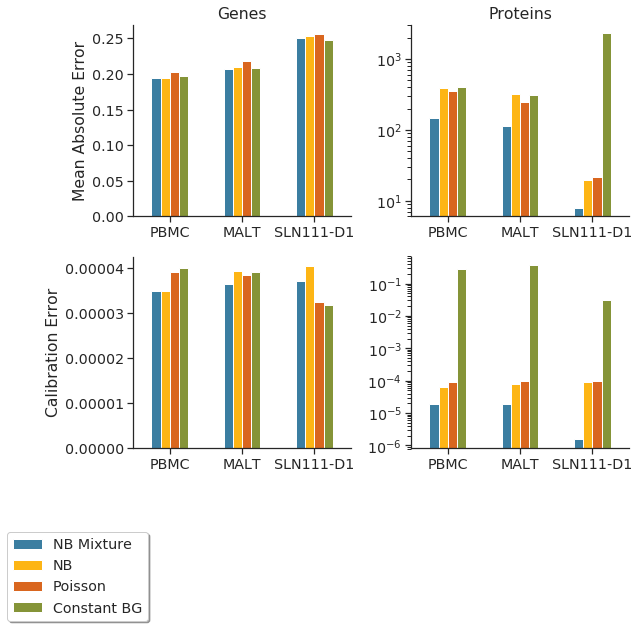

In [15]:
ppc_bar_plots(key="mean_ae")
plt.tight_layout()
plt.savefig("figures/totalvi_ppc/mae_cal.pdf")

In [16]:
for p in ppc_helds:
    del p

In [17]:
# del p for p in ppc_helds
ppc_fulls = [ppc_full_pbmc, ppc_full_malt, ppc_full_sln]

In [18]:
# Runtime warning is when samples have all zeros, we consider this as 0 cv
for p in ppc_fulls:
    p.coeff_of_variation(cell_wise=False)

../utils/totalppc.py:115: RuntimeWarning: invalid value encountered in true_divide
  np.std(samples, axis=axis) / np.mean(samples, axis=axis), axis=-1


In [19]:
cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln = {}, {}, {}
cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln = {}, {}, {}
cv_gene_maes = [cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln]
cv_pro_maes = [cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln]

for p, dataset, cv_gene_mae, cv_pro_mae in zip(ppc_fulls, datasets, cv_gene_maes, cv_pro_maes):
    for m, samples in p.posterior_predictive_samples.items():
        cv_gene_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[: dataset.nb_genes]
                - p.metrics["cv_gene"]["raw"].iloc[: dataset.nb_genes]
            )
        )]
        cv_pro_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[dataset.nb_genes:]
                - p.metrics["cv_gene"]["raw"].iloc[dataset.nb_genes:]
            )
        )]
    p.metrics["cv_gene_mae"] = pd.DataFrame.from_dict(cv_gene_mae)
    p.metrics["cv_pro_mae"] = pd.DataFrame.from_dict(cv_pro_mae)

In [20]:
(p.metrics["cv_gene_mae"].iloc[: dataset.nb_genes] == 0).sum(axis=0)

NB Mixture     0
NB             0
Poisson        0
Constant BG    0
dtype: int64

[[0.81 0.8  0.71 0.74]]
[['0.81' '0.8' '0.71' '0.74' '--']]
[[1.53 1.41 1.56 1.39]]
[['1.53' '1.41' '1.56' '1.39' '--']]
[[1.05 1.04 1.29 1.23]]
[['1.05' '1.04' '1.29' '1.23' '--']]


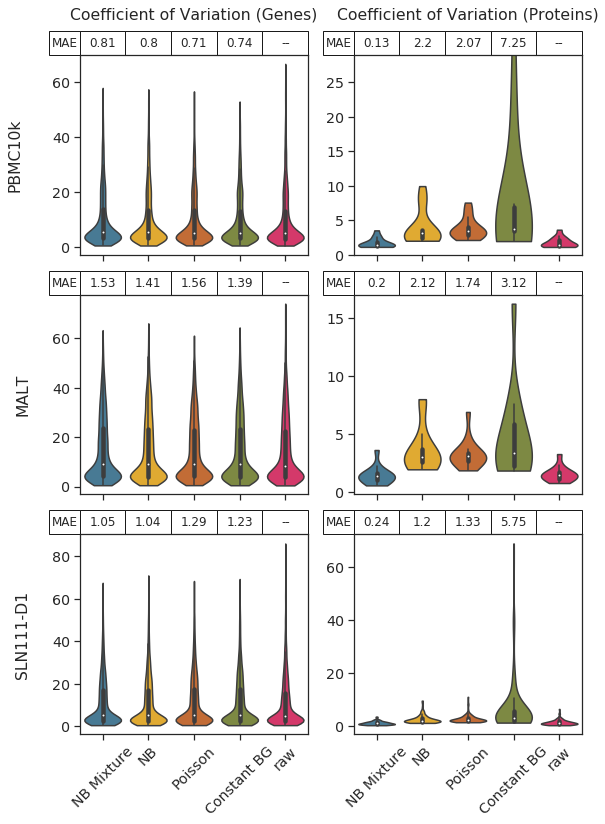

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(9, 12.5), sharex=False)
inds = [0, 2, 4]
for i, p, dataset in zip(inds, ppc_fulls, datasets):
    gene_table = np.round(p.metrics["cv_gene_mae"].values, 2)
    print(gene_table)
    gene_table = np.concatenate([gene_table, np.array(["--"]).reshape(1, 1)], axis=1)
    print(gene_table)
    pro_table = np.round(p.metrics["cv_pro_mae"].values, 2)
    pro_table = np.concatenate([pro_table, np.array(["--"]).reshape(1, 1)], axis=1)
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[: dataset.nb_genes],
        ax=ax.flat[i],
        cut=0,
        scale="count",
#         order=["totalVI", "scVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i].table(
        cellText=gene_table, rowLabels=["MAE"], loc="top", cellLoc="center"
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)
    
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[dataset.nb_genes :],
        ax=ax.flat[i + 1],
        cut=0,
        scale="count",
#         order=["totalVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i + 1].table(
        cellText=pro_table,
        loc="top",
        cellLoc="center",
        rowLabels=["MAE"],
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)

title = ax.flat[0].set_title("Coefficient of Variation (Genes)")
title.set_position([0.5, 1.15])
title = ax.flat[1].set_title("Coefficient of Variation (Proteins)")
title.set_position([0.5, 1.15])
ax.flat[1].set_ylim(0, 29)
ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[3].set_xticklabels([])
ax.flat[4].tick_params(axis="x", rotation=45)
ax.flat[5].tick_params(axis="x", rotation=45)
ax.flat[0].set_ylabel("PBMC10k", labelpad=30)
ax.flat[2].set_ylabel("MALT", labelpad=22)
ax.flat[4].set_ylabel("SLN111-D1", labelpad=22)
# sns.despine()

# plt.tight_layout()
plt.savefig("figures/totalvi_ppc/violins_cv.pdf", bbox_inches="tight")